# Stedden Budgeting Notebook

This notebook is part of an ongoing project to analyze our overall income and expenses.  The primary aim is to use this information to fairly reallocate money between Claire and Will.  In addition, we wish to use this data to inform our behavior.


first import and load data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import ipy_budget_api as ipybudget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline
plt.style.use('seaborn-pastel')
sns.set_style(sns.axes_style("darkgrid"))

here I use my [ipy-budget package](https://github.com/lots-of-things/ipy-budget) to download data from our online gsheets [budget](https://docs.google.com/spreadsheets/d/1XiSlpguUG_YGU9TQ0b8dJheeCMYNR6xNAg_cluXsrGk/edit?usp=sharing). (NOTE: this data has been edited to obscure income and spending details)

In [2]:
budget_data = ipybudget.get_budget_data('1XiSlpguUG_YGU9TQ0b8dJheeCMYNR6xNAg_cluXsrGk')
budget_data['year'] = budget_data['date'].dt.year
budget_data['month_of_year'] = budget_data['date'].dt.month
budget_data['month'] = budget_data['date'].dt.to_period('M')
budget_data['quarter'] = budget_data['date'].dt.to_period('Q')
time_granularity = 'quarter'

In [3]:
def sum_abs(x):
    return np.abs(x.sum())
def sum_neg(x):
    return -x.sum()

# Income

- Viewing net income after tax and refunds
- note in Q1 2017 we left grad school and started earning more money (fake data)

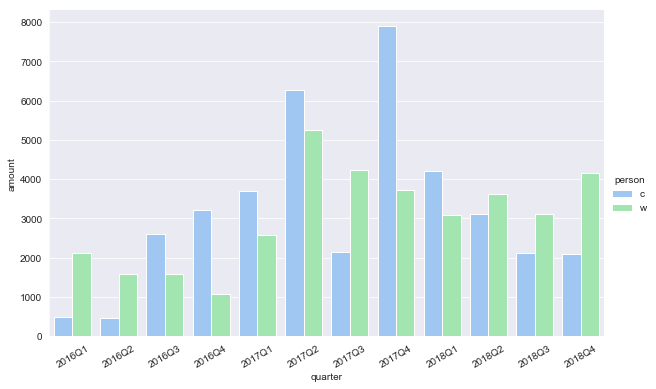

In [4]:
to_plot = budget_data[budget_data['category'].isin(('inc','tax'))].sort_values('person')
g = sns.catplot(time_granularity, 'amount',hue='person',kind="bar",sharex=False,sharey=False,order=to_plot[time_granularity].sort_values().unique(),estimator=sum,ci=None,data=to_plot,height=6,aspect=1.5,facet_kws={"gridspec_kws":{"hspace":0.2}})
g.set_xticklabels(rotation=30)

### We are withdrawing our retirement investments from our current income
we make the assumption that this is an expense. So we will only realize that as income when we withdraw from the investment.
similarly, tax is subtracted from income 

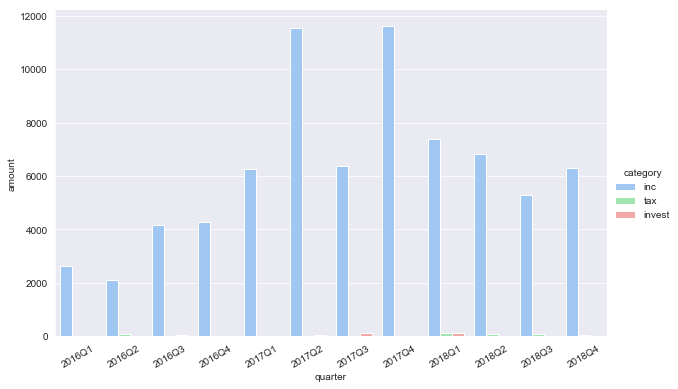

In [5]:
to_plot = budget_data[budget_data['category'].isin(('inc','tax','invest'))].sort_values('person')
g = sns.catplot(time_granularity, 'amount',hue='category',kind="bar",sharex=False,sharey=False,order=to_plot[time_granularity].sort_values().unique(),estimator=sum_abs,ci=None,data=to_plot,height=6,aspect=1.5,facet_kws={"gridspec_kws":{"hspace":0.2}})
g.set_xticklabels(rotation=30)

# Spending

- Viewing all categories of spending to assist in detecting accounting errors and unexpected behaviors
- note that claire seems to be paying the same or more across almost all sectors

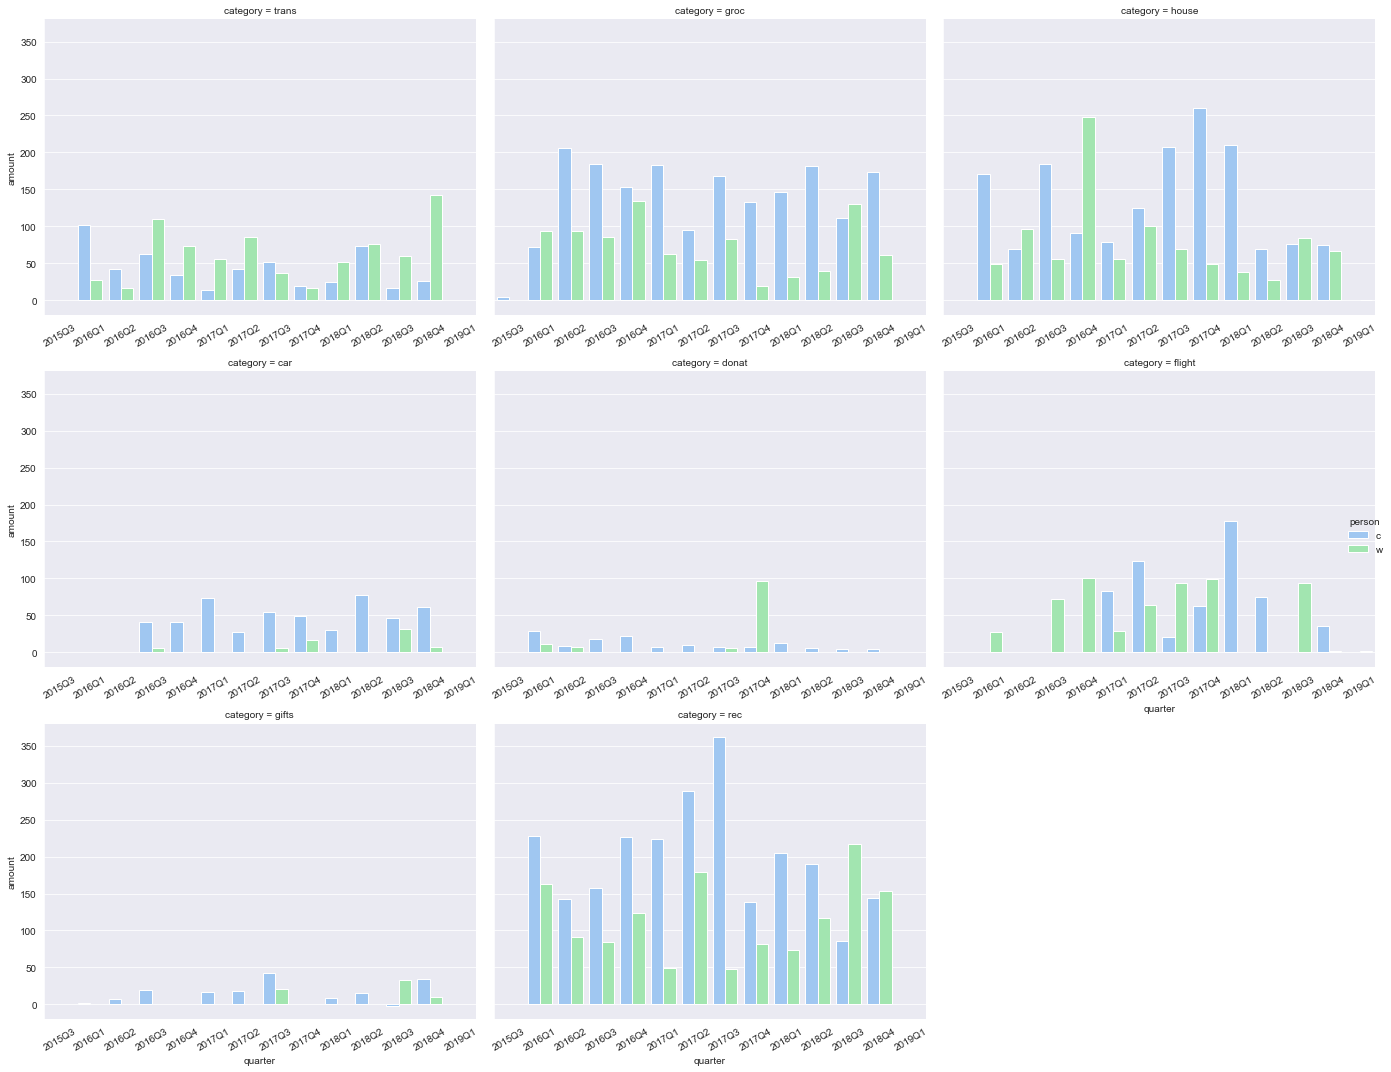

In [6]:
to_plot = budget_data[~budget_data['category'].isin(('inc','tax','redis','invest','wedding','rent','med','boat','work'))].sort_values('person')
g = sns.catplot(time_granularity, 'amount',col="category",col_wrap=3,hue='person',kind="bar",sharex=False,sharey=True,order=to_plot[time_granularity].sort_values().unique(),estimator=sum_neg,ci=None,data=to_plot,height=5,aspect=1.25,facet_kws={"gridspec_kws":{"hspace":0.2}})
g.set_xticklabels(rotation=30)
plt.tight_layout()

Higher cost categories

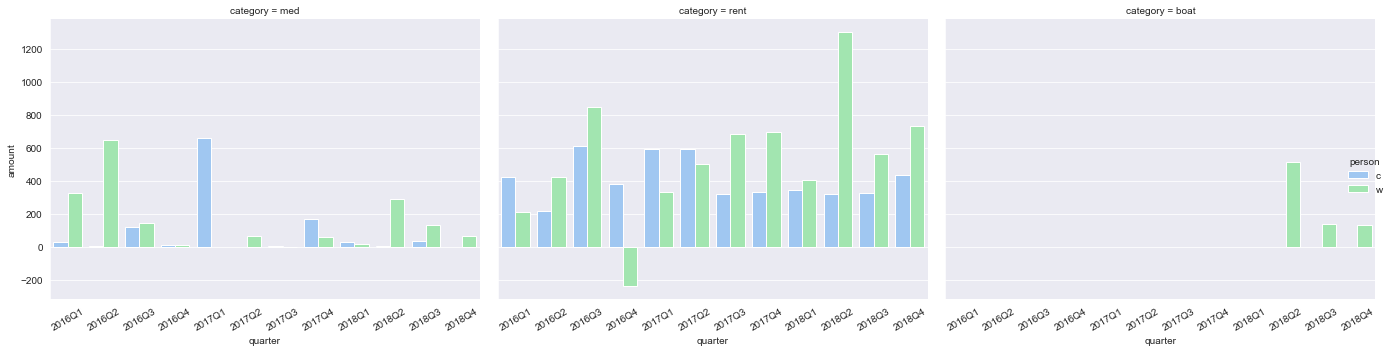

In [7]:
to_plot = budget_data[budget_data['category'].isin(('rent','med','boat'))].sort_values('person')
g = sns.catplot(time_granularity, 'amount',col="category",col_wrap=3,hue='person',kind="bar",sharex=False,sharey=True,order=to_plot[time_granularity].sort_values().unique(),estimator=sum_neg,ci=None,data=to_plot,height=5,aspect=1.25,facet_kws={"gridspec_kws":{"hspace":0.2}})
g.set_xticklabels(rotation=30)
plt.tight_layout()

# Splitting expenses by income

trying to define how to fairly divide income. would like to split expenses proportional to our income, but there are 2 ways to do that:

1. locally - in each period calculate how much each made and split expenses accordingly
2. globally - keep a running tally of income and expenses and ensure that the totals are fairly split 

In [8]:
# compute variables for shared expenses and income
income = (budget_data[budget_data['category'].isin(('inc','tax','redis'))].groupby(['quarter','person']).sum().reset_index().pivot(index='quarter',columns='person',values='amount')).fillna(0)
income.columns.name=''

income['total quarterly income'] = income['c']+income['w']
income['total cumulative income'] = income['total quarterly income'].cumsum()
income['Claire\'s local share of income'] = income['c']/income['total quarterly income']
income['Claire\'s global share of income'] = income['c'].cumsum()/income['total cumulative income']
income['Claire\'s income'] = income['c']
income['Will\'s income'] = income['w']

shared_expenses = (budget_data[(~budget_data['category'].isin(('inc','tax','redis'))) & (budget_data['shared']=='y')].groupby(['quarter','person']).sum().reset_index().pivot(index='quarter',columns='person',values='amount')).fillna(0)
shared_expenses.columns.name=''

shared_expenses['total quarterly expenses'] = (shared_expenses['c']+shared_expenses['w'])
shared_expenses['total cumulative expenses'] = shared_expenses['total quarterly expenses'].cumsum()
shared_expenses['Claire\'s local share of expenses'] = shared_expenses['c']/shared_expenses['total quarterly expenses']
shared_expenses['Claire\'s global share of expenses'] = shared_expenses['c'].cumsum()/shared_expenses['total cumulative expenses']
shared_expenses['Claire\'s expenses'] = shared_expenses['c']
shared_expenses['Will\'s expenses'] = shared_expenses['w']

accounting = income.drop(['c','w'],axis=1).merge(shared_expenses.drop(['c','w'],axis=1),on='quarter').fillna(0)

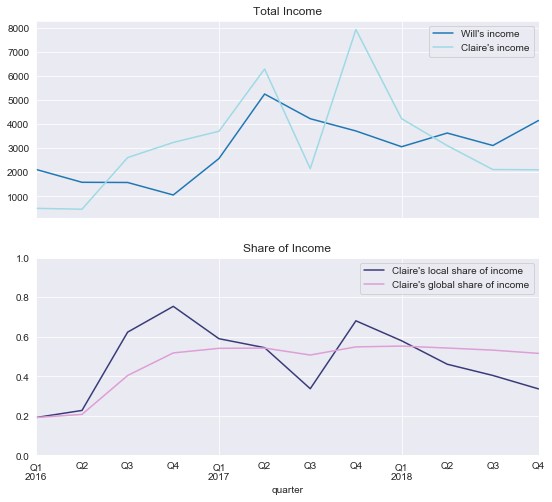

In [9]:
f,ax=plt.subplots(2,1,figsize=(9,8),sharex=True)
accounting.plot(y=['Will\'s income','Claire\'s income'],ax=ax[0],cmap=cm.get_cmap('tab20'))
a=ax[0].set_title('Total Income')
accounting.plot(y=['Claire\'s local share of income','Claire\'s global share of income'],ax=ax[1],cmap=cm.get_cmap('tab20b'))
a=ax[1].set_title('Share of Income')
a=plt.ylim([0,1])

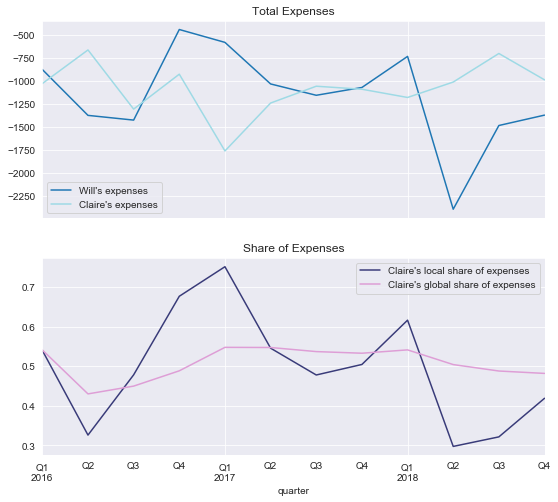

In [10]:
f,ax=plt.subplots(2,1,figsize=(9,8),sharex=True)
accounting.plot(y=['Will\'s expenses','Claire\'s expenses'],ax=ax[0],cmap=cm.get_cmap('tab20'))
a=ax[0].set_title('Total Expenses')
accounting.plot(y=['Claire\'s local share of expenses','Claire\'s global share of expenses'],ax=ax[1],cmap=cm.get_cmap('tab20b'))
a=ax[1].set_title('Share of Expenses')

## Comparing finance sharing by global vs local method

clearly much lower variability in global method

(0, 0.8)

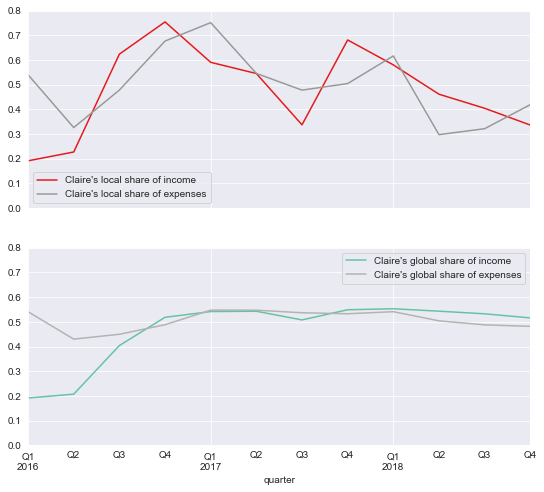

In [11]:
f,ax=plt.subplots(2,1,figsize=(9,8),sharex=True)
accounting.plot(y=['Claire\'s local share of income','Claire\'s local share of expenses'],ax=ax[0],cmap=cm.get_cmap('Set1'))
accounting.plot(y=['Claire\'s global share of income','Claire\'s global share of expenses'],ax=ax[1],cmap=cm.get_cmap('Set2'))
ax[0].set_ylim([0,0.8])
ax[1].set_ylim([0,0.8])

# Computing Claire's overpayment
- Claire pays more bills despite making less money.  meaning I need to pay her back.
- Note that the global method actually works out worse for me, but I still prefer it for fairness sake.

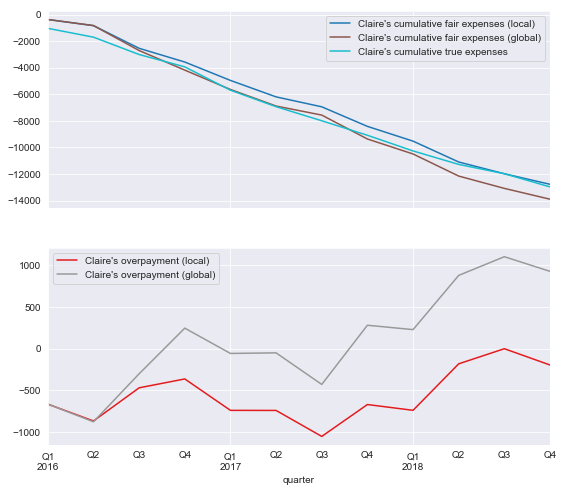

In [12]:
accounting['Claire\'s cumulative fair expenses (local)'] = (accounting['total quarterly expenses']*accounting['Claire\'s local share of income']).cumsum()
accounting['Claire\'s cumulative fair expenses (global)'] = accounting['total cumulative expenses']*accounting['Claire\'s global share of income']
accounting['Claire\'s cumulative true expenses'] = (accounting['total quarterly expenses']*accounting['Claire\'s local share of expenses']).cumsum()
accounting['Claire\'s overpayment (local)'] = accounting['Claire\'s cumulative true expenses'] - accounting['Claire\'s cumulative fair expenses (local)']
accounting['Claire\'s overpayment (global)'] = accounting['Claire\'s cumulative true expenses'] - accounting['Claire\'s cumulative fair expenses (global)']

f,ax=plt.subplots(2,1,figsize=(9,8),sharex=True)
accounting.plot(y=['Claire\'s cumulative fair expenses (local)','Claire\'s cumulative fair expenses (global)','Claire\'s cumulative true expenses'],cmap=cm.get_cmap('tab10'),ax=ax[0])
accounting.plot(y=['Claire\'s overpayment (local)','Claire\'s overpayment (global)'],cmap=cm.get_cmap('Set1'),ax=ax[1])

## Conclusion
Using global income & expenses method to calculate total owed to claire...

In [24]:
income = budget_data.loc[budget_data['category'].isin(('inc','tax','redis'))].groupby('person')['amount'].sum()
expense = budget_data.loc[~budget_data['category'].isin(('inc','tax','redis')) & (budget_data['shared']=='y')].groupby('person')['amount'].sum()
print('Will owes Claire: ${}'.format(int(expense['c']-(income['c']/income.sum())*expense.sum())))
      

Will owes Claire: $924


### Appendix: Individual Transactions

- Distribution of individual transactions broken down by year
- less variability year to year than expected

In [14]:
cats = set(budget_data['category'].unique())-{'inc','tax','redis','invest','work'}
cats = [c for c in cats if ((budget_data['category']==c) & (budget_data['amount']>0)).sum()>50]
f, axes = plt.subplots(int(len(cats)/2), 2, figsize=(10, 2*len(cats)))
for i,cat in enumerate(cats):
    subset = (budget_data['category']==cat) & (budget_data['amount']>0)
    mn = budget_data.loc[subset,'amount'].min()
    mx = budget_data.loc[subset,'amount'].max()
    stp = 5 if mx <500 else 10 if mx < 1000 else 50
    for y in [2016,2017,2018]:
        sns.distplot(budget_data.loc[subset & (budget_data['year']==y),'amount'],ax=axes[i % int(len(cats)/2), i // int(len(cats)/2)],label=y,bins=np.arange(mn,mx+stp,stp),kde=False,norm_hist=True).set_title('individual {} purchases: median={}'.format(cat,int(budget_data.loc[subset,'amount'].median())))
    axes[i % int(len(cats)/2), i // int(len(cats)/2)].legend()
f.tight_layout()

<Figure size 720x0 with 0 Axes>